In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

import warnings
warnings.filterwarnings('ignore')

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='********',
    database='ecommerce'
)
cur = db.cursor()

# Basic Queries

## Q1) list all unique cities where customers are located.

In [46]:
query = """ select distinct Customer_city  from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customer_city"])

df

,Customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


## Q2) Count the number of orders placed in 2017.

In [6]:
query = """ select count(*) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 45101)

## Q3) Find the total sales per category.

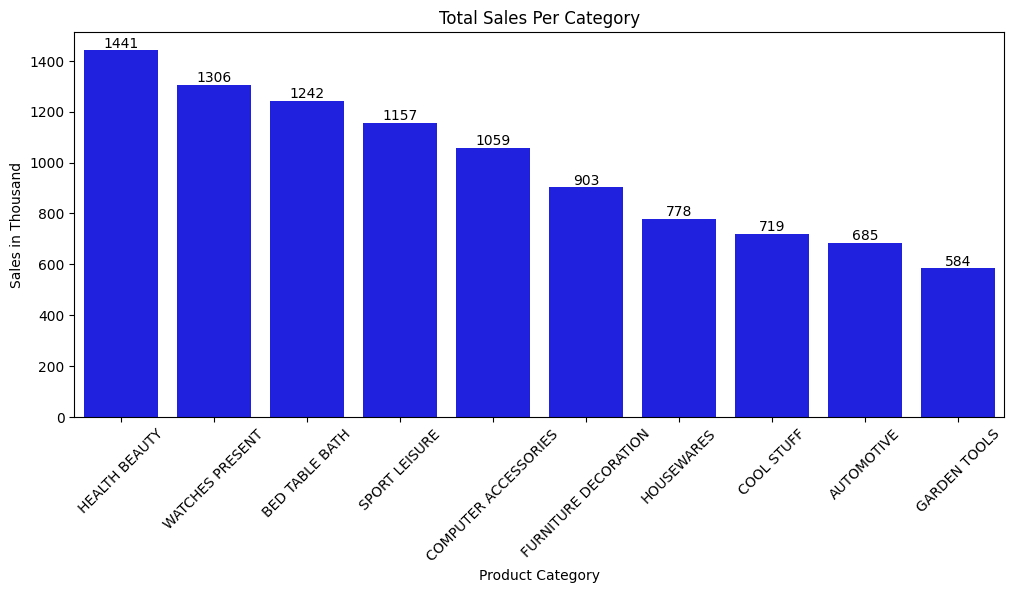

In [248]:
query = """ select upper(p.product_category),
round(SUM(oi.price + oi.freight_value)/1000) total_sales 
from products p 
join order_items oi 
on p.product_id = oi.product_id 
group by p.product_category
order by total_sales desc
limit 10
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['product_category', 'Sales'])

plt.figure(figsize = (12,5))
ax = sns.barplot(x=df['product_category'], y=df['Sales'], color= 'blue')
plt.xlabel("Product Category")
plt.ylabel("Sales in Thousand")
plt.title("Total Sales Per Category")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.show()

## Q4) Calculate the percentage of orders that were paid in installments.

In [38]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end) /count(*))*100
from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments",data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

## Q5) Count the number of customers from each state. 

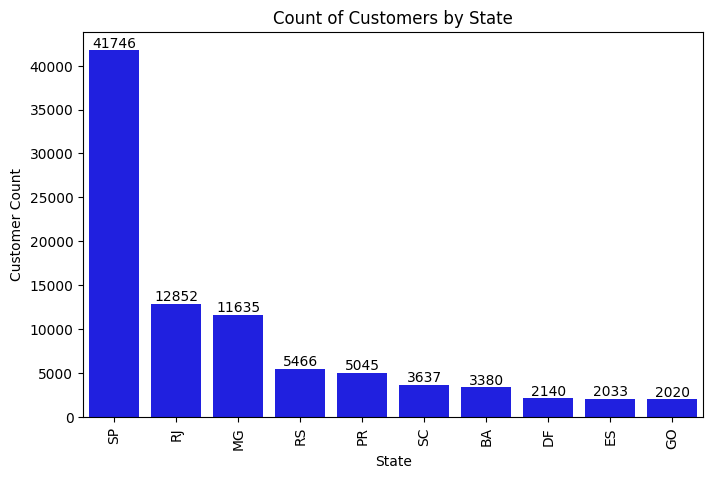

In [208]:
query = """ select customer_state, count(*) as cust_count
from customers
group by customer_state
order by cust_count desc
limit 10
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])


plt.figure(figsize = (8,5))
ax = sns.barplot(x=df['state'], y=df['customer_count'], color= 'blue')
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("Count of Customers by State")
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.show()

# Intermediate Queries

## Q1) Calculate the number of orders per month in 2018.

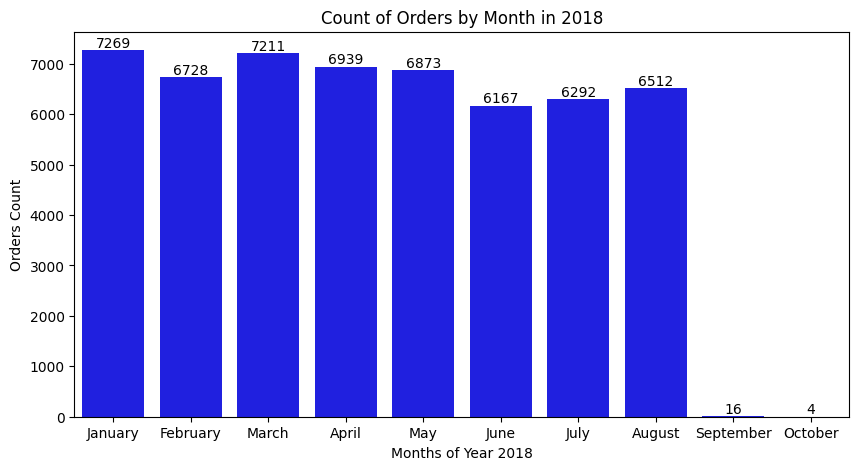

In [250]:
query = """ select monthname(order_purchase_timestamp) as months, count(order_id)
from orders
where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Month", "orders_count"])
o= ["January","February","March","April","May","June","July","August","September","October"]

plt.figure(figsize = (10,5))
ax = sns.barplot(x=df['Month'], y=df['orders_count'], order = o, color = 'blue')
plt.xlabel("Months of Year 2018")
plt.ylabel("Orders Count")
plt.title("Count of Orders by Month in 2018")
ax.bar_label(ax.containers[0])
plt.show()

# Q2) Find the average number of products per order, grouped by customer city.

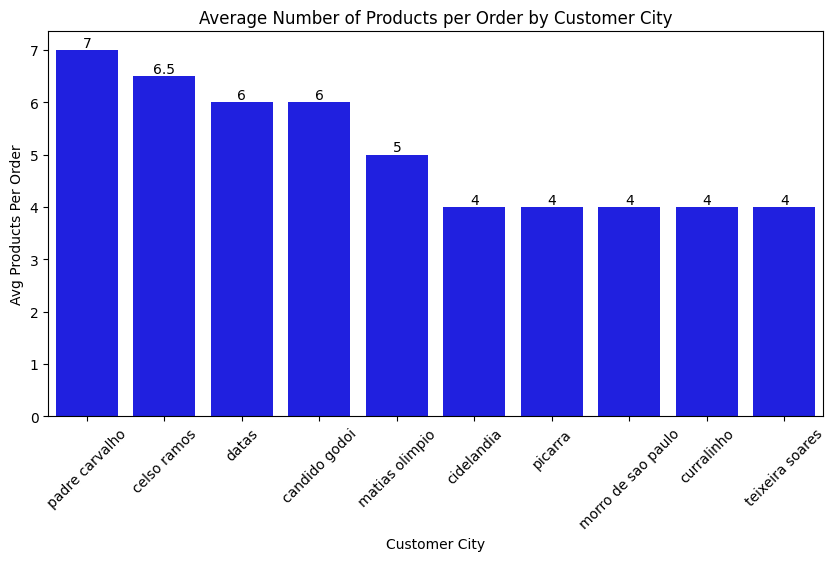

In [162]:
query = """ with count_per_order as
(select o.order_id, o.customer_id, count(oi.order_id) order_count
from orders o
join order_items oi
on o.order_id = oi.order_id
group by o.order_id, o.customer_id)

select c.customer_city, round(avg(cpo.order_count),2) avg_order_count
from customers c
join count_per_order cpo
on c.customer_id = cpo.customer_id
group by c.customer_city
order by avg_order_count desc
limit 10
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customer_city", "avg_products_per_order"])

df

plt.figure(figsize = (10,5))
ax = sns.barplot(x=df['Customer_city'], y=df['avg_products_per_order'], color = 'blue')
plt.xlabel("Customer City")
plt.ylabel("Avg Products Per Order")
plt.title("Average Number of Products per Order by Customer City")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.show()

## Q3. Calculate the percentage of total revenue contributed by each product category.

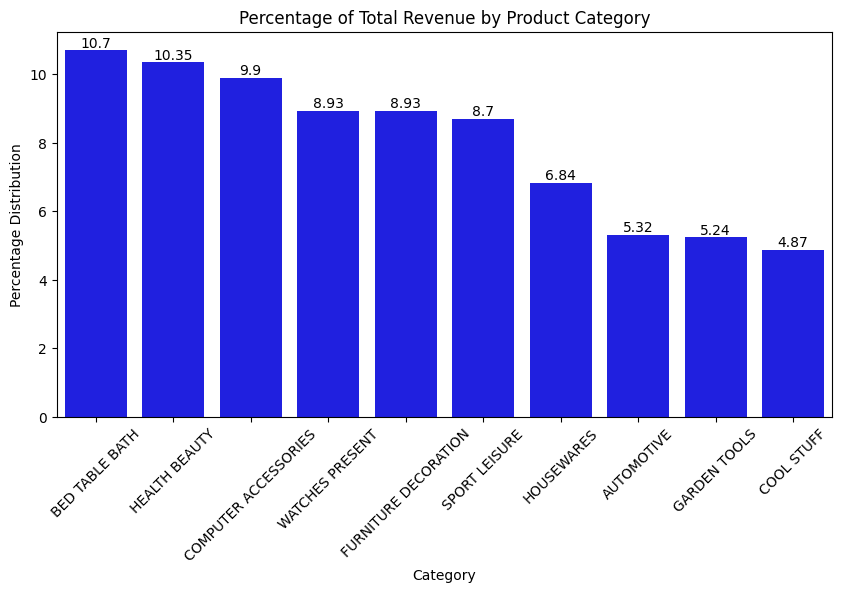

In [196]:
query = """ select upper(p.product_category) category,
round((sum(payments.payment_value)/ (select sum(payments.payment_value) from payments))*100,2) percentage_distribution
from products p 
join order_items oi 
on p.product_id = oi.product_id
join payments
on payments.order_id = oi.order_id
group by p.product_category
order by percentage_distribution desc
limit 10
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category", "percentage_distribution"])

plt.figure(figsize = (10,5))
ax = sns.barplot(x=df['category'], y=df['percentage_distribution'], color = 'blue')
plt.xlabel("Category")
plt.ylabel("Percentage Distribution")
plt.title("Percentage of Total Revenue by Product Category")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.show()

## Q4) Identify the correlation between product price and the number of times a product has been purchased.

The correlation between price and number of times a product has been purchased is -0.11


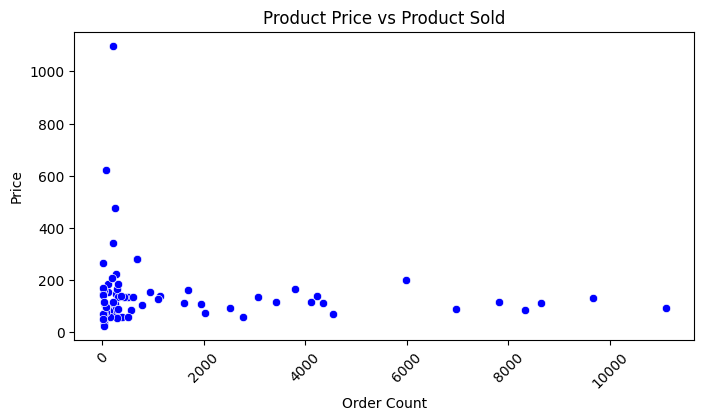

In [31]:
query = """ select p.product_category, 
count(oi.product_id), 
round(avg(oi.price),2) avg_price
from products p
join order_items oi
on p.product_id = oi.product_id
group by p.product_category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category", "order_count", "price"])

arr1 = df['order_count']
arr2 = df['price']
a = np.corrcoef([arr1,arr2])
print("The correlation between price and number of times a product has been purchased is",round(a[0][1],2))

plt.figure(figsize = (8,4))
sns.scatterplot(x=df['order_count'], y=df['price'], color = 'blue')
plt.xlabel("Order Count")
plt.ylabel("Price")
plt.title("Product Price vs Product Sold")
plt.xticks(rotation = 45)

plt.show()

## Q5) Calculate the total revenue generated by each seller, and rank them by revenue.

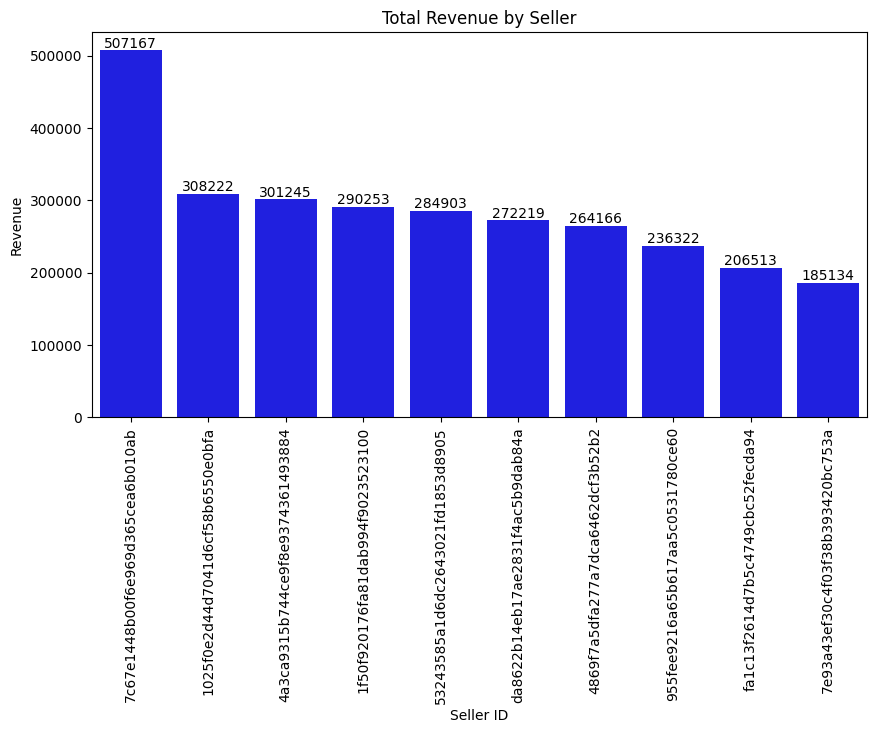

In [39]:
query = """ select *, dense_rank() over (order by revenue desc) as ranks from 
(select oi.seller_id, sum(p.payment_value) revenue
from order_items oi
join payments p
on oi.order_id = p.order_id
group by oi.seller_id) a
limit 10;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Seller_id", "Revenue", "Rank"])


plt.figure(figsize = (10,5))
ax = sns.barplot(x=df['Seller_id'], y=df['Revenue'], color = 'blue')
plt.xlabel("Seller ID")
plt.ylabel("Revenue")
plt.title("Total Revenue by Seller")
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.show()

# Advanced Queries

# Q1) Calculate the moving average of order values for each customer over their order history.

In [5]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg 
from
(select o.customer_id, o.order_purchase_timestamp, p.payment_value as payment
from orders o
join payments p
on o.order_id = p.order_id)a
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "payment","moving_avg"])
df

,customer_id,order_purchase_timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Q2) Calculate the cumulative sales per month for each year.

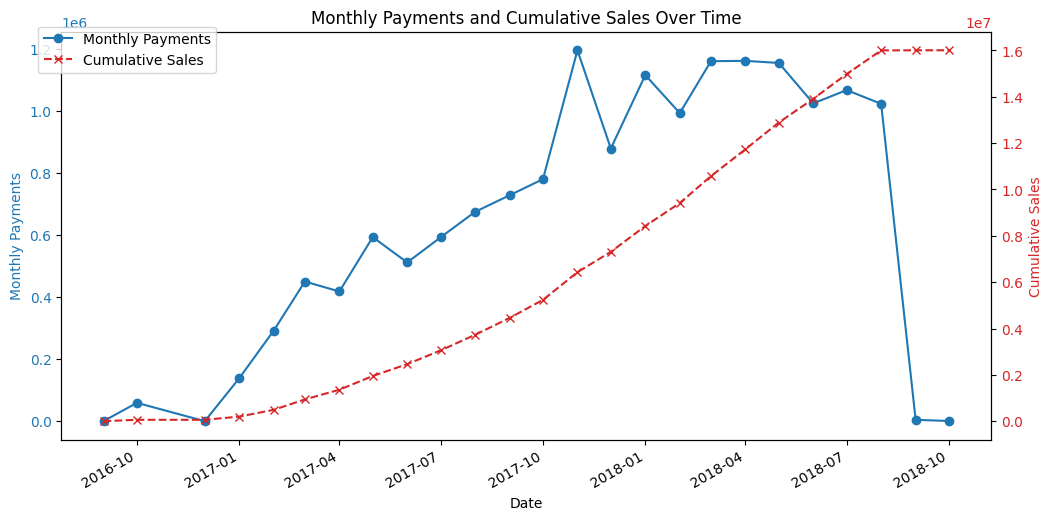

In [3]:
query = """ select years, months, payments, sum(payments)
over(order by years, months) as cumulative_sales
from
(select year(o.order_purchase_timestamp) years, 
month(order_purchase_timestamp) months,
round(sum(p.payment_value),2) payments
from orders o
join payments p
on o.order_id = p.order_id
group by years, months
order by years, months) a
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years", "months", "payments","cumulative_sales"])

import pandas as pd
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['years'].astype(str) + '-' + df['months'].astype(str) + '-01')
df = df.sort_values('date')
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Payments', color='tab:blue')
ax1.plot(df['date'], df['payments'], color='tab:blue', marker='o', label='Monthly Payments')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative Sales', color='tab:red')
ax2.plot(df['date'], df['cumulative_sales'], color='tab:red', marker='x', linestyle='--', label='Cumulative Sales')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title('Monthly Payments and Cumulative Sales Over Time')
fig.autofmt_xdate()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

# Q3) Calculate the year-over-year growth rate of total sales.

In [28]:
query = """with a as (select year(o.order_purchase_timestamp) years, 
round(sum(p.payment_value),2) payments
from orders o
join payments p
on o.order_id = p.order_id
group by years
order by years)

select years, 
((payments- lag(payments,1) over(order by years))/ lag(payments,1) over(order by years))*100 
as yoy_Growth from a
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Years", "YOY % Growth"])

df

,Years,YOY % Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Q4) Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [31]:
query = """ with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) as next_order_count
from a join orders
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp > a.first_order
and orders.order_purchase_timestamp > date_add(a.first_order, interval 6 month)
group by a.customer_id) 

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) as retension_rate
from a join b
on a.customer_id = b.customer_id
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["retension_rate"])

df

,retension_rate
0,None


# Q5) Identify the top 3 customers who spent the most money in each year.

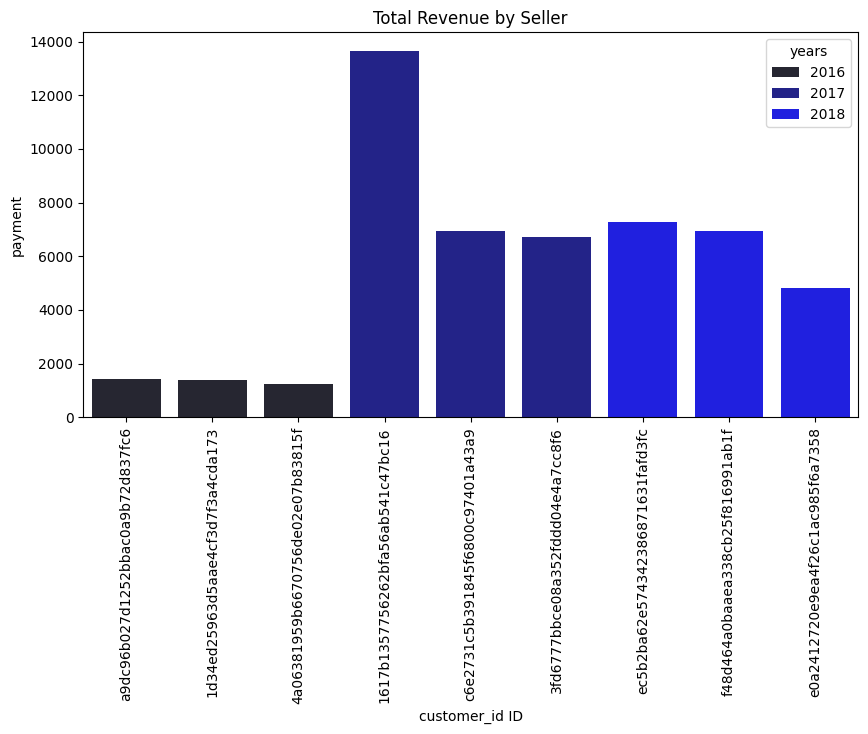

In [48]:
query = """ select *
from 
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) as d_rank
from orders join payments
on orders.order_id = payments.order_id
group by years, orders.customer_id) a
where d_rank <=3 
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years", "customer_id", "payment","d_rank"])

plt.figure(figsize = (10,5))
sns.barplot(x=df['customer_id'], y=df['payment'], hue = df['years'], color = 'blue')
plt.xlabel("customer_id ID")
plt.ylabel("payment")
plt.title("Total Revenue by Seller")
plt.xticks(rotation = 90)
plt.show()